# Customer Churn Prediction Project
# Author: Diptesh Karmakar
# Date: December 2024


This project aims to predict customer churn for a subscription-based service using machine learning.
We'll go through data analysis, preprocessing, feature engineering, and model building to create
a reliable churn prediction system.



## 1. Initial Setup and Data Loading

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set styling for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('/kaggle/input/bank-data/churn.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())


Dataset Shape: (10000, 14)

First few rows of the dataset:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113

## 2. Exploratory Data Analysis (EDA)

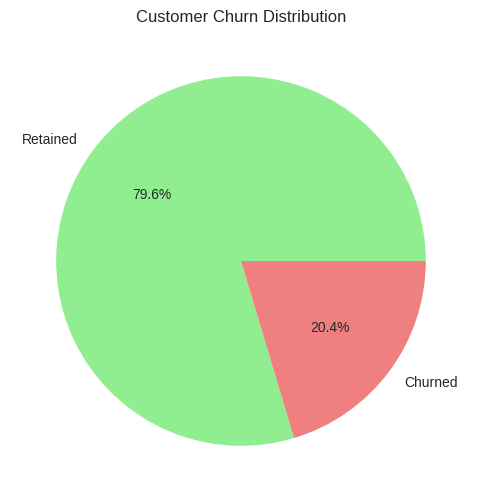

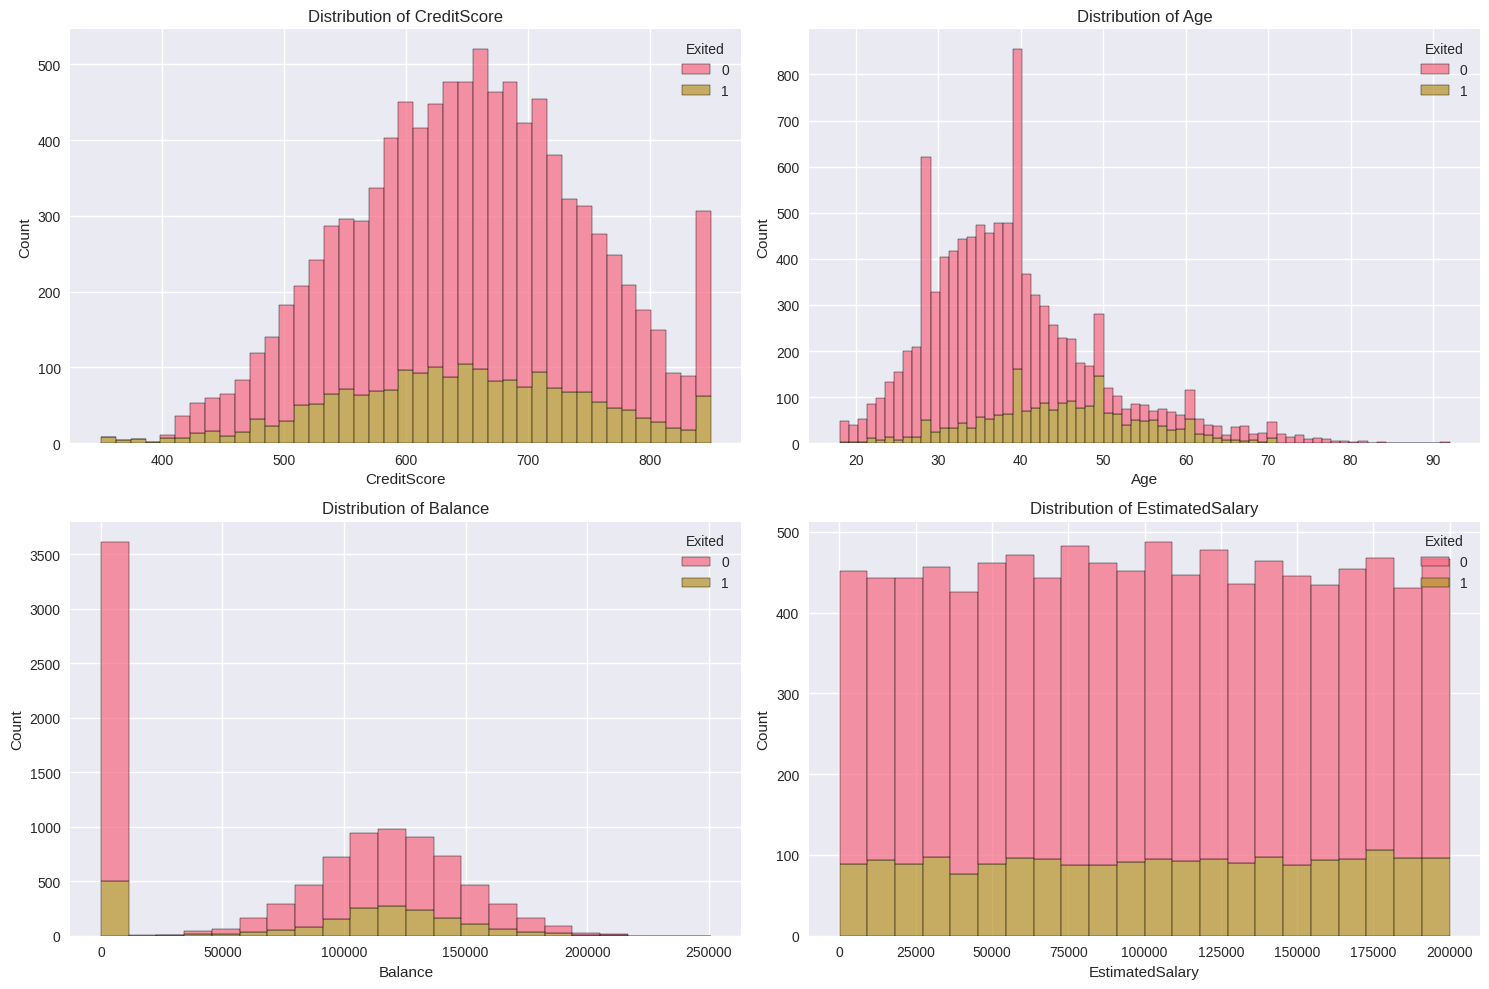

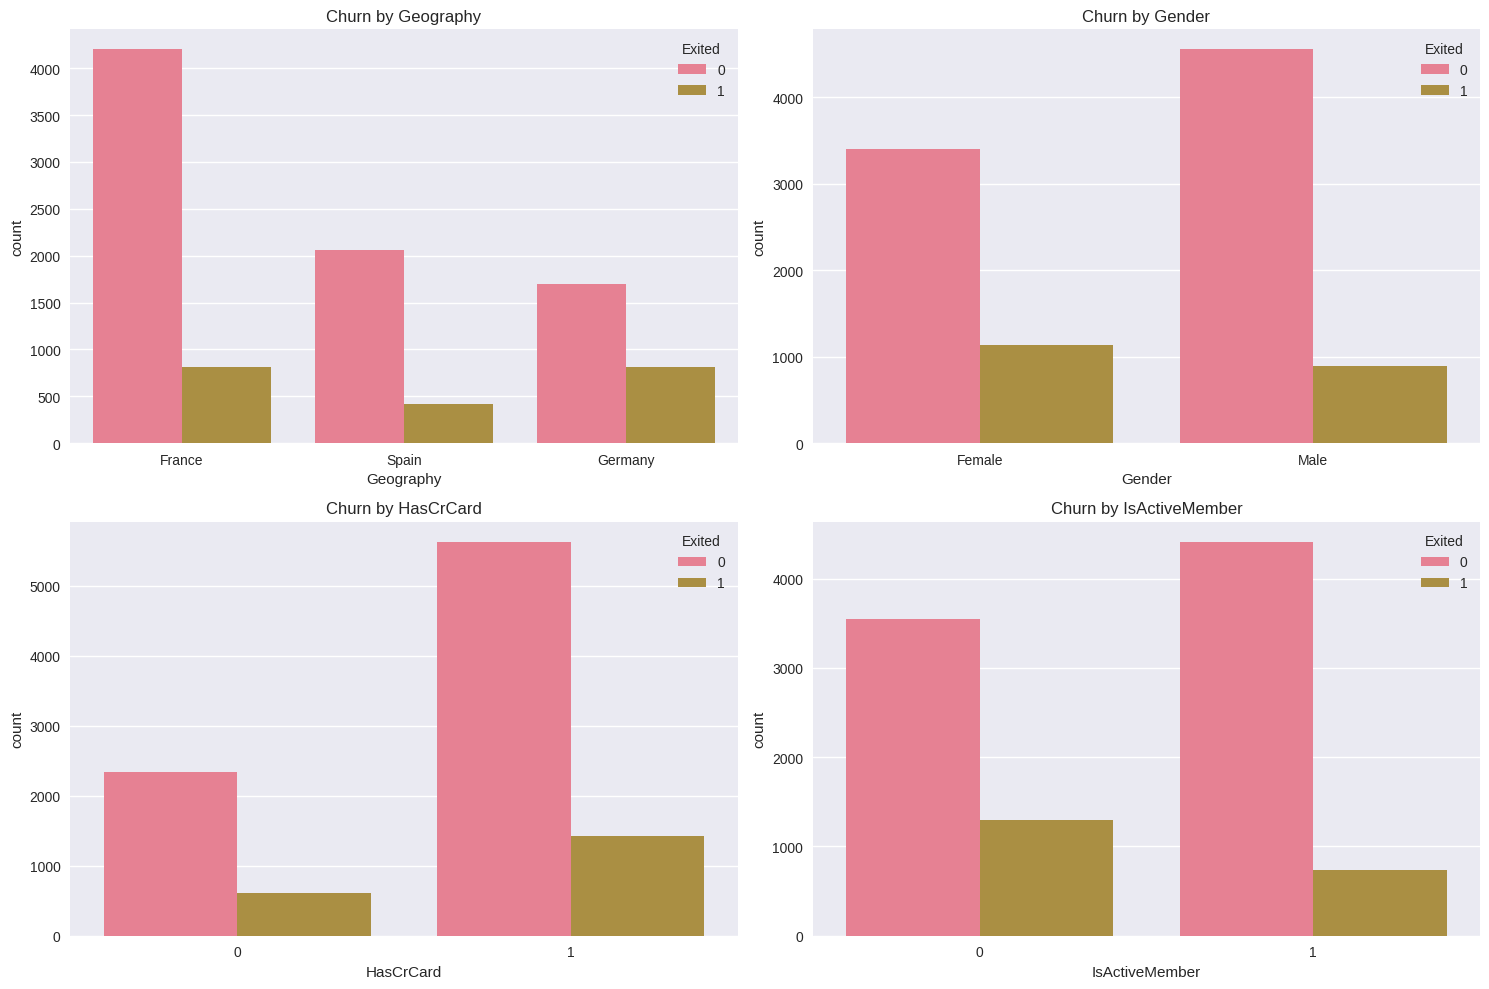

In [14]:
def plot_churn_distribution():
    """Plot the distribution of churned vs non-churned customers"""
    plt.figure(figsize=(10,6))
    plt.pie(df['Exited'].value_counts(), 
            labels=['Retained', 'Churned'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'])
    plt.title('Customer Churn Distribution')
    plt.show()

def plot_numeric_distributions():
    """Plot distributions of important numeric variables"""
    numeric_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for i, col in enumerate(numeric_cols):
        sns.histplot(data=df, x=col, hue='Exited', 
                    multiple="stack",
                    ax=axes[i//2, i%2])
        axes[i//2, i%2].set_title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

def plot_categorical_relationships():
    """Plot relationships between categorical variables and churn"""
    categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for i, col in enumerate(categorical_cols):
        sns.countplot(data=df, x=col, hue='Exited',
                     ax=axes[i//2, i%2])
        axes[i//2, i%2].set_title(f'Churn by {col}')
    plt.tight_layout()
    plt.show()

# Execute EDA functions
plot_churn_distribution()
plot_numeric_distributions()
plot_categorical_relationships()


## 3. Data Preprocessing

In [15]:
def preprocess_data(df):
    """
    Preprocess the dataset by handling missing values, encoding categorical variables,
    and scaling numeric features.
    """
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Drop unnecessary columns
    df_processed.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
    
    # Encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['Geography', 'Gender']
    for col in categorical_cols:
        df_processed[col] = le.fit_transform(df_processed[col])
    
    # Scale numeric features
    scaler = StandardScaler()
    numeric_cols = ['CreditScore', 'Balance', 'EstimatedSalary']
    df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])
    
    return df_processed


## 4. Feature Engineering

In [16]:
def engineer_features(df):
    """
    Create new features based on existing ones to potentially improve model performance.
    """
    df['Balance_per_Product'] = df['Balance'] / df['NumOfProducts']
    df['Age_Tenure_Ratio'] = df['Age'] / (df['Tenure'] + 1)
    df['Credit_Balance_Ratio'] = df['CreditScore'] / (df['Balance'] + 1)
    df['Products_per_Tenure'] = df['NumOfProducts'] / (df['Tenure'] + 1)
    
    return df

# Process the data
df_processed = preprocess_data(df)
df_processed = engineer_features(df_processed)


## 5. Model Building and Training

In [17]:
# Split features and target
X = df_processed.drop('Exited', axis=1)
y = df_processed['Exited']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Define models and their parameter grids
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_leaf': [1, 2],
            'random_state': [42]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'random_state': [42]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'random_state': [42]
        }
    }
}


## Train and Evaluate Models


Results for Random Forest:
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1607
           1       0.57      0.63      0.60       393

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.84      2000



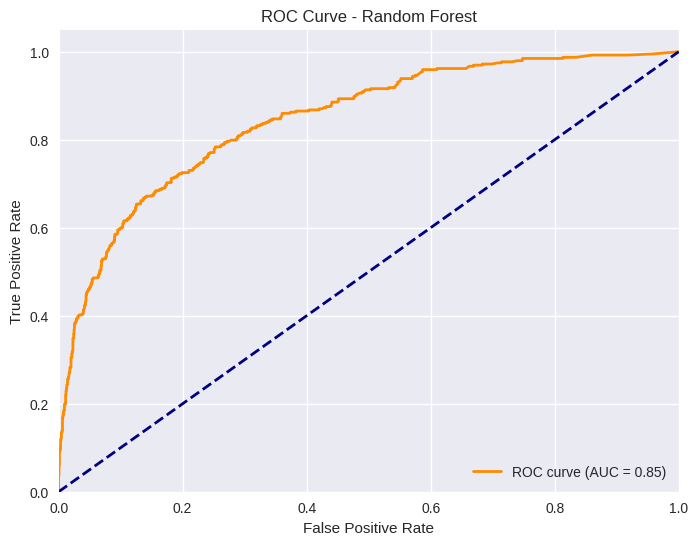

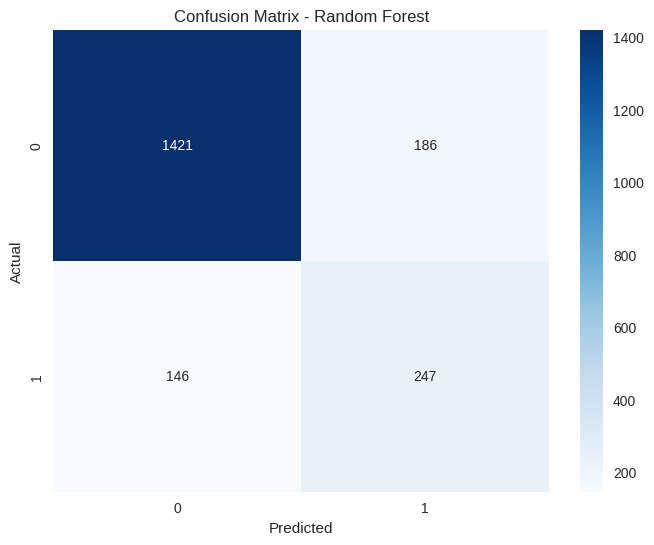


Results for XGBoost:
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1607
           1       0.56      0.65      0.60       393

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.84      2000



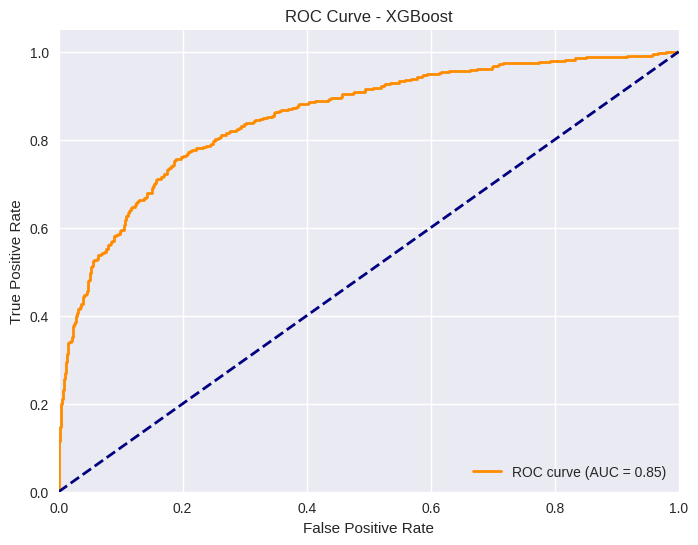

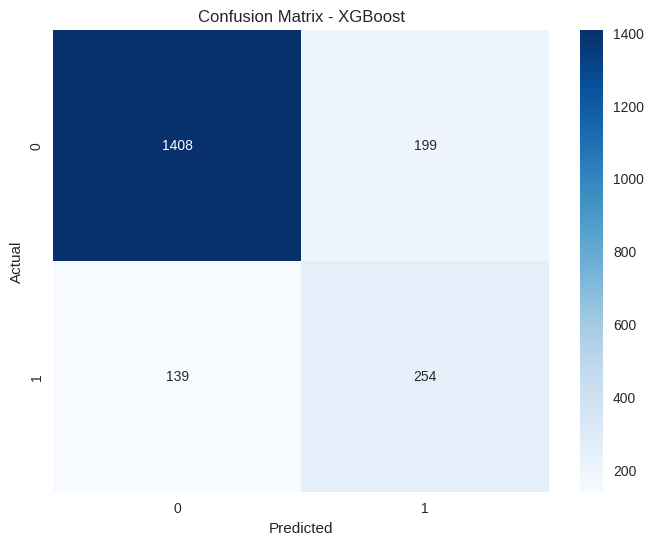


Results for Gradient Boosting:
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1607
           1       0.56      0.63      0.59       393

    accuracy                           0.83      2000
   macro avg       0.73      0.75      0.74      2000
weighted avg       0.84      0.83      0.83      2000



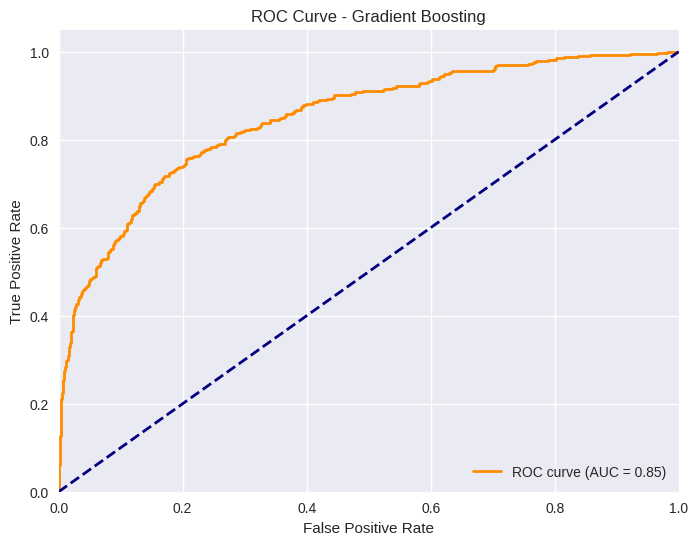

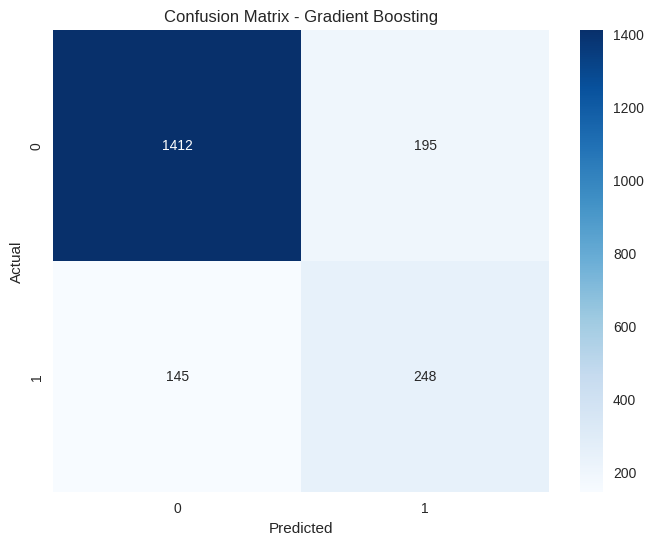

In [18]:
def train_evaluate_model(model_name, model, params, X_train, y_train, X_test, y_test):
    """
    Train a model using GridSearchCV and evaluate its performance
    """
    # Perform grid search
    grid_search = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    
    # Calculate metrics
    print(f"\nResults for {model_name}:")
    print("Best parameters:", grid_search.best_params_)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return best_model

# Train and evaluate all models
best_models = {}
for model_name, model_info in models.items():
    best_models[model_name] = train_evaluate_model(
        model_name,
        model_info['model'],
        model_info['params'],
        X_train_balanced,
        y_train_balanced,
        X_test,
        y_test
    )


## 6. Feature Importance Analysis and Saving the Best Model

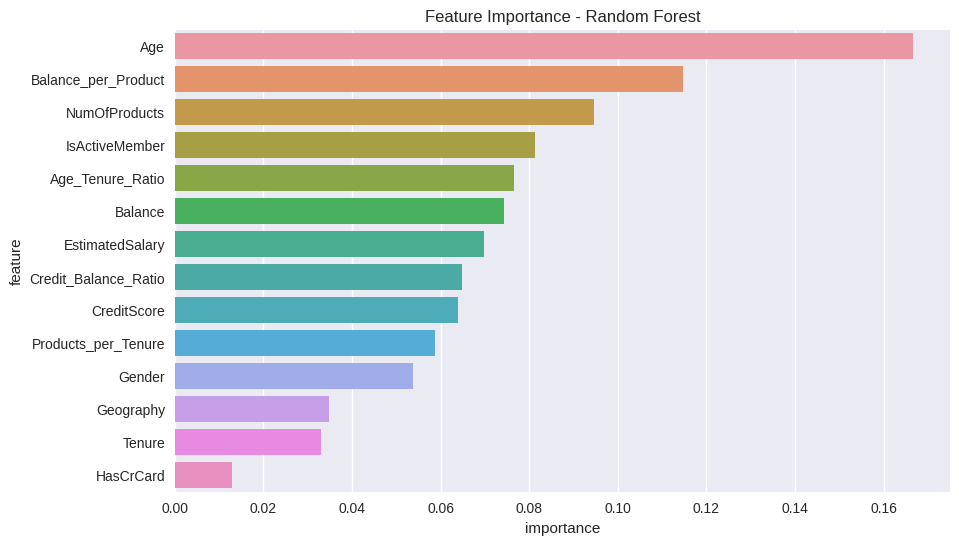

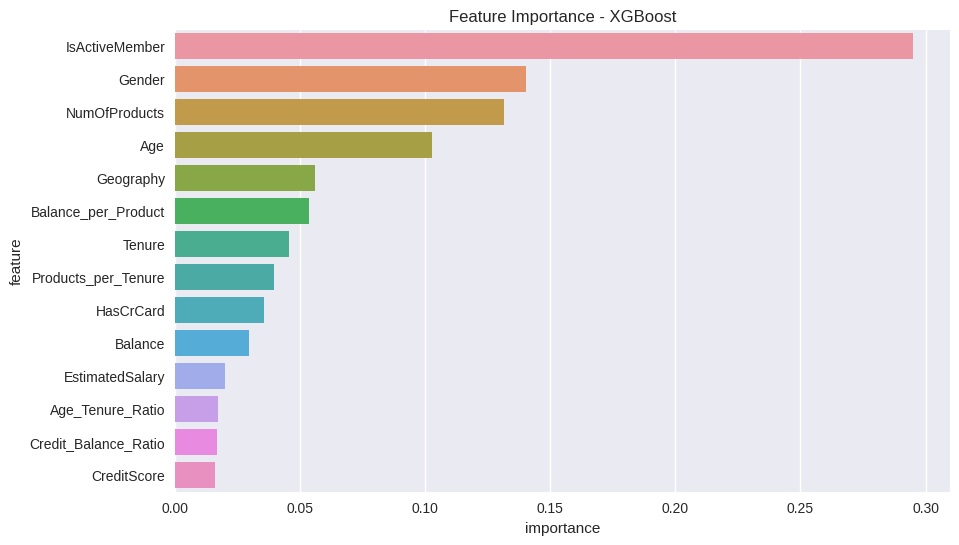

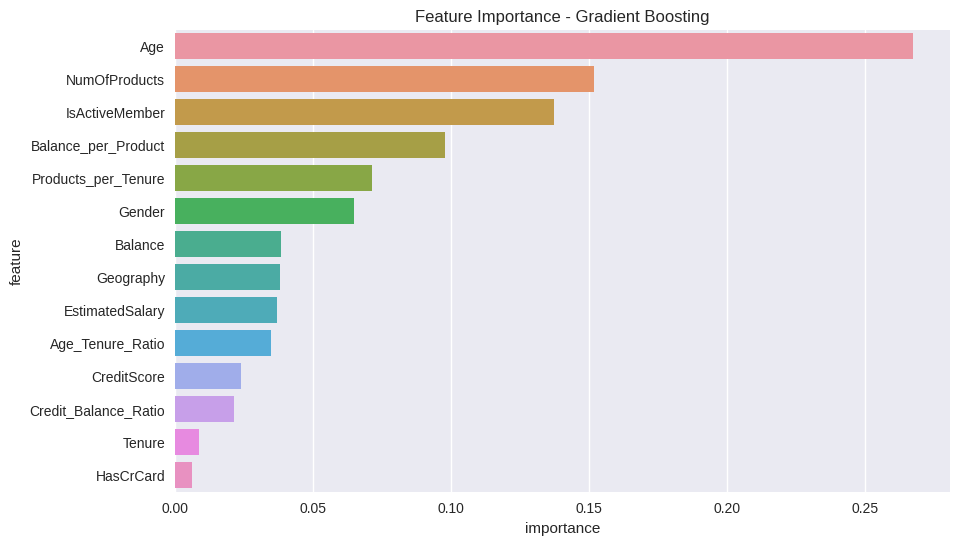


Best performing model (Random Forest) has been saved as 'best_churn_model.joblib'


In [19]:
def plot_feature_importance(model, model_name):
    """
    Plot feature importance for the given model
    """
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_imp = pd.DataFrame({
            'feature': X_train.columns,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_imp)
        plt.title(f'Feature Importance - {model_name}')
        plt.show()

# Plot feature importance for each model
for model_name, model in best_models.items():
    plot_feature_importance(model, model_name)

# Save the best model for later use
import joblib
best_model_name = max(best_models.keys(), key=lambda k: best_models[k].score(X_test, y_test))
joblib.dump(best_models[best_model_name], 'best_churn_model.joblib')
print(f"\nBest performing model ({best_model_name}) has been saved as 'best_churn_model.joblib'")
